In [13]:
import torch
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pandas as pd
import numpy as np
import glob

In [14]:
sns.set_context("talk")
sns.set_style("whitegrid")

In [15]:
prefix = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm'

In [16]:
def get_lastest_runlogs(save_path, run_path):
    """gather the log of the lastest run and return log as data frame."""
    logs_sorted_by_time = sorted(glob.glob(os.path.join(save_path, run_path, '*.json')))
    if len(logs_sorted_by_time)>0:
        found_all_chuncks = False
        i = 1
        logs = []
        while not found_all_chuncks:
            file = logs_sorted_by_time[-i]
            
            with open(file) as f:
                lines = f.readlines()[1:]
            if len(lines)>0:

                logs.append([json.loads(line) for line in lines])
                epoch = json.loads(lines[0])['epoch']
                # print(i, file, epoch)
                if epoch==1:
                    found_all_chuncks = True
            
            i+=1

            
        return pd.DataFrame([line for log in logs[::-1] for line in log ])

    else:
        print(save_path, run_path)
        raise FileNotFoundError
  

In [17]:
def learning_curves_comparsion(file_prefixes, titles): 
    performance = []
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(prefix, f'{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(100).mean().plot(
            use_index=False, label=title, ax=axs[0], alpha=0.5)

        performance.append({'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'title': title,
                            'auc': logs[logs['mode']=='val'].head4_auc.max(), 
                            'prauc': logs[logs['mode']=='val'].head4_prauc.max()
                            })

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc' in logs:

            logs[logs['mode']=='val'].head4_prauc.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()
    
    plt.show()
    return pd.DataFrame(performance)   

In [18]:
file_prefixes = [
        # ('ffdm', 'swav_resnet18_milatten1_batch128', 'locality_atten', ''),
         ('ffdm', 'nyu_ffdm_screening/imagenet', '', 'locality_atten'),
                # ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'locality_atten'), 
                # ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'pretrained_head_1e3'),
                ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'pretrained_head_1e2'), 
                ('ffdm', 'nyu_ffdm_screening/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32', '', 'locality_atten'),  
                #  ('ffdm', 'resnet50_imagenet_supervised', 'nyu_ffdm_screening', '')
                ('ffdm', 'nyu_ffdm_screening/swav_resnet18_milatten1_batch128/focalloss', '', 'pretrained_head_1e2'), 

                 ]

### Impact of Focal loss
* nyu_ffdm_screening/swav_resnet18_milatten1_batch128/focalloss/pretrained_head_1e2
* nyu_ffdm_screening/swav_resnet18_milatten1_batch128/pretrained_head_1e2

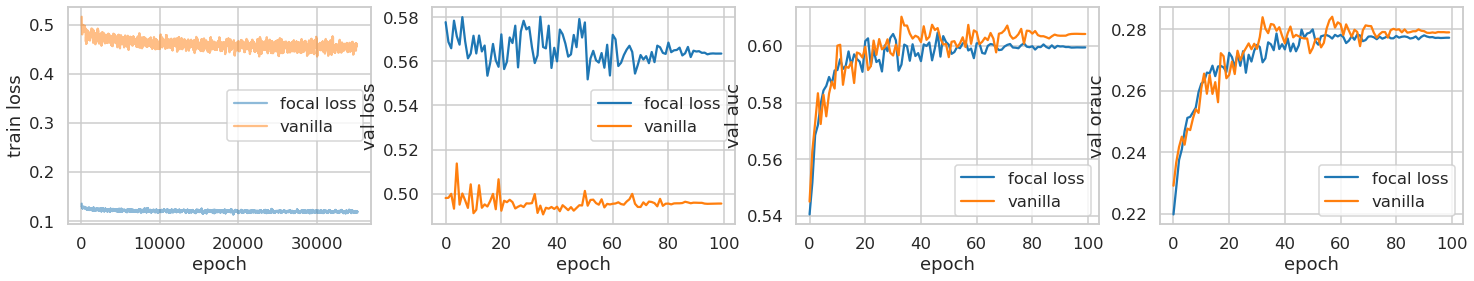

,pretrain-exp,exp,weight init,title,auc,prauc
0,nyu_ffdm_screening/swav_resnet18_milatten1_bat...,focalloss/,1e2,focal loss,0.60471,0.28001
1,nyu_ffdm_screening/swav_resnet18_milatten1_bat...,,1e2,vanilla,0.61030,0.28413


In [19]:
file_prefixes = [
                 ('nyu_ffdm_screening/swav_resnet18_milatten1_batch128', 'focalloss/', 'pretrained_head_1e2'),
                 ('nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'pretrained_head_1e2'),
                 ]
titles = ['focal loss', 'vanilla']
performance = learning_curves_comparsion(file_prefixes, titles)
performance

### Imagenet
* nyu_ffdm_screening/imagenet/locality_atten [1e-4]

### Vanilla 
* nyu_ffdm_screening/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32/locality_atten [1e-4]


### Attention 
* nyu_ffdm_screening/swav_resnet18_milatten1_batch128/locality_atten [1e-4]
* nyu_ffdm_screening/swav_resnet18_milatten1_batch128/pretrained_head_1e2 [1e-2]
* nyu_ffdm_screening/swav_resnet18_milatten1_batch128/pretrained_head_1e3 [1e-3]

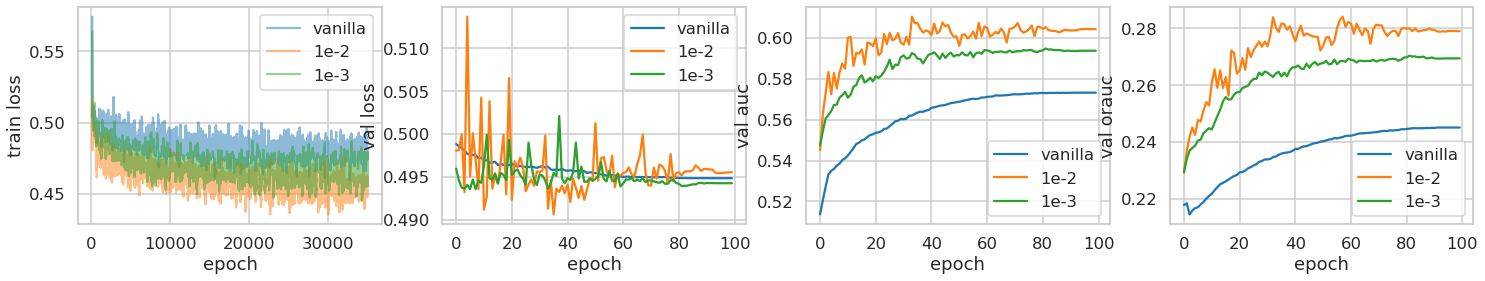

In [20]:
file_prefixes = [
                 ('nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'locality_atten'),
                 ('nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'pretrained_head_1e2'),
                 ('nyu_ffdm_screening/swav_resnet18_milatten1_batch128', '', 'pretrained_head_1e3'),
                 ]
titles = ['vanilla', '1e-2', '1e-3']
performance = learning_curves_comparsion(file_prefixes, titles)

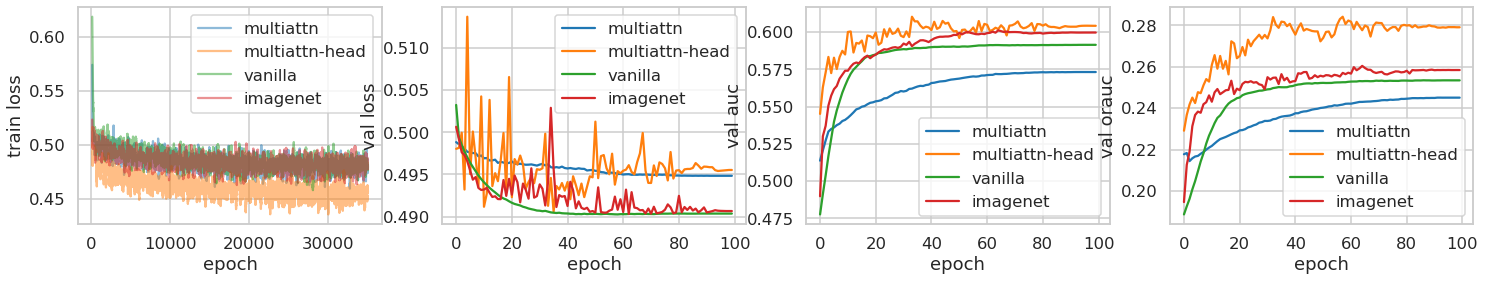

,pretrain-exp,exp,weight init,title,auc,prauc
0,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,atten,multiattn,0.57319,0.24508
1,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,1e2,multiattn-head,0.61030,0.28413
2,nyu_ffdm_screening,swav_resnet18_avgpool_coslr-100e_largebatch_sk...,atten,vanilla,0.59144,0.25345
3,nyu_ffdm_screening,imagenet/,atten,imagenet,0.60119,0.26041


In [27]:
file_prefixes = [
                 ('nyu_ffdm_screening', 'swav_resnet18_milatten1_batch128/', 'locality_atten'),
                 ('nyu_ffdm_screening', 'swav_resnet18_milatten1_batch128/', 'pretrained_head_1e2'),
                 ('nyu_ffdm_screening', 'swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32/', 'locality_atten'),
                  ('nyu_ffdm_screening', 'imagenet/', 'locality_atten'),
                 ]
titles = ['multiattn', 'multiattn-head', 'vanilla', 'imagenet']
performance = learning_curves_comparsion(file_prefixes, titles)
performance

In [29]:
save_prefix = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyu_readerstudy_mammo/'
results = []
for (path, exp, winit), title  in zip(file_prefixes, titles):

    logs_sorted_by_time = sorted(glob.glob(os.path.join(save_prefix, f'{path}/{exp}{winit}', '*.log')))
    if len(logs_sorted_by_time)>0:  
        with open(logs_sorted_by_time[-1]) as f:
            lines = f.readlines()
        scores = {'title': title}
        for line in lines:
            col, item = line.split('-')[-1][:-1].strip().split(':')
            scores.update({col: float(item)})
        results.append(scores)

performance.merge(pd.DataFrame(results), on='title')

,pretrain-exp,exp,weight init,title,auc,prauc,head4_auc,head4_prauc
0,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,atten,multiattn,0.57319,0.24508,0.612,0.085
1,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,1e2,multiattn-head,0.61030,0.28413,0.661,0.115
2,nyu_ffdm_screening,swav_resnet18_avgpool_coslr-100e_largebatch_sk...,atten,vanilla,0.59144,0.25345,0.627,0.084
3,nyu_ffdm_screening,imagenet/,atten,imagenet,0.60119,0.26041,0.623,0.076


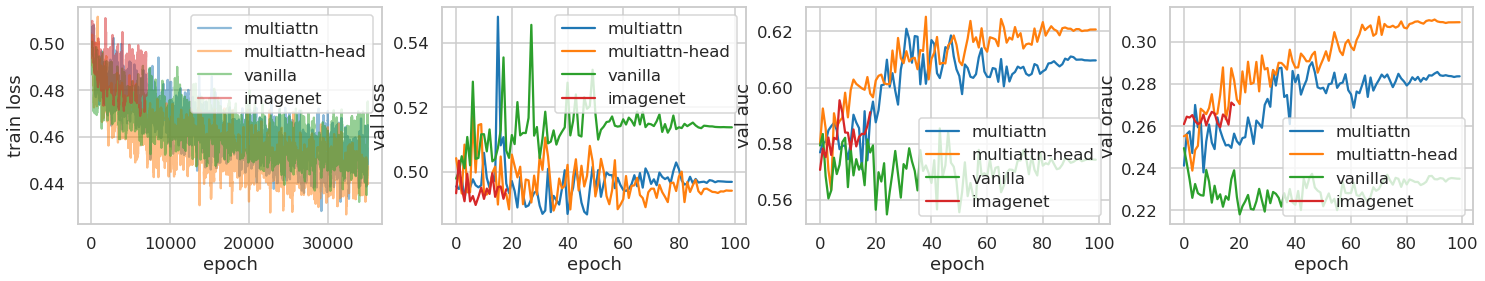

,pretrain-exp,exp,weight init,title,auc,prauc
0,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,Adam1e-2,multiattn,0.62094,0.29040
1,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,Adam1e-2,multiattn-head,0.62522,0.31206
2,nyu_ffdm_screening,swav_resnet18_avgpool_coslr-100e_largebatch_sk...,Adam1e-2,vanilla,0.58547,0.24954
3,nyu_ffdm_screening,imagenet/,Adam1e-3,imagenet,0.59550,0.27124


In [36]:

file_prefixes = [
                 ('nyu_ffdm_screening', 'swav_resnet18_milatten1_batch128/', 'Adam1e-2'),

                 ('nyu_ffdm_screening', 'swav_resnet18_milatten1_batch128/', 'pretrained_head_Adam1e-2'),
                 ('nyu_ffdm_screening', 'swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32/', 'Adam1e-2'),
                #   ('nyu_ffdm_screening', 'imagenet/', 'Adam1e-2'),
                    ('nyu_ffdm_screening', 'imagenet/', 'Adam1e-3'),
                 ]
titles = ['multiattn', 'multiattn-head', 'vanilla', 'imagenet']
performance = learning_curves_comparsion(file_prefixes, titles)
performance

In [35]:

"""
export PREFIX='/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/nyu_ffdm_screening'
export SAVE='/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyu_readerstudy_mammo/nyu_ffdm_screening'
bsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch \
    --master_addr="127.0.0.1" \
    --master_port=29500 \
    --nproc_per_node=1 \
    tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py \
    $PREFIX/swav_resnet18_milatten1_batch128/Adam1e-2/latest.pth \
    --work-dir $SAVE/swav_resnet18_milatten1_batch128/Adam1e-2 \
    --launcher="pytorch" \
    --breast 

bsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch \
    --master_addr="127.0.0.1" \
    --master_port=29500 \
    --nproc_per_node=1 \
    tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py \
    $PREFIX/swav_resnet18_milatten1_batch128/pretrained_head_Adam1e-2/latest.pth \
    --work-dir $SAVE/swav_resnet18_milatten1_batch128/pretrained_head_Adam1e-2 \
    --launcher="pytorch" \
    --breast 
    
bsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch \
    --master_addr="127.0.0.1" \
    --master_port=29500 \
    --nproc_per_node=1 \
    tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py \
    $PREFIX/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32/Adam1e-2/latest.pth \
    --work-dir $SAVE/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32/Adam1e-2 \
    --launcher="pytorch" --breast  

bsub -q short -Is -n 20 -gpu "num=$GPUS:mode=shared:j_exclusive=yes" python -m torch.distributed.launch \
    --master_addr="127.0.0.2" \
    --master_port=29501 \
    --nproc_per_node=1 \
    tools/test.py configs/benchmarks/classification/nyubreast/ffdm/nyu_readerstudy.py \
    $PREFIX/imagenet/Adam1e-2/latest.pth \
    --work-dir $SAVE/imagenet/Adam1e-2 \
    --launcher="pytorch" --breast  \
    --cfg-options data.val.data_source.color_type='color' model.backbone.in_channels=3
"""

save_prefix = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyu_readerstudy_mammo/'
results = []
for (path, exp, winit), title  in zip(file_prefixes, titles):

    logs_sorted_by_time = sorted(glob.glob(os.path.join(save_prefix, f'{path}/{exp}{winit}', '*.log')))
    if len(logs_sorted_by_time)>0:  
        with open(logs_sorted_by_time[-1]) as f:
            lines = f.readlines()
        scores = {'title': title}
        for line in lines:
            col, item = line.split('-')[-1][:-1].strip().split(':')
            scores.update({col: float(item)})
        results.append(scores)

performance.merge(pd.DataFrame(results), on='title')

,pretrain-exp,exp,weight init,title,auc,prauc,head4_auc,head4_prauc
0,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,Adam1e-2,multiattn,0.62094,0.29040,0.663,0.115
1,nyu_ffdm_screening,swav_resnet18_milatten1_batch128/,Adam1e-2,multiattn-head,0.62522,0.31206,0.698,0.145
2,nyu_ffdm_screening,swav_resnet18_avgpool_coslr-100e_largebatch_sk...,Adam1e-2,vanilla,0.58547,0.24954,0.623,0.072
